In [2]:
!pip install -U "ultralytics>=8.2.70" opencv-python pillow tqdm --quiet

import ultralytics, torch, sys, platform
print("ultralytics:", ultralytics.__version__)
print("torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("python:", sys.version.split()[0], "| OS:", platform.platform())

ultralytics: 8.3.221
torch: 2.8.0+cu126 | CUDA: True
python: 3.12.12 | OS: Linux-6.6.105+-x86_64-with-glibc2.35


In [1]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pathlib import Path
import cv2, json, csv
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import SAM

# 원본 이미지 로드
BASE = Path("/content/drive/MyDrive/AI챌린지/2025-ssafy-14")
TRAIN_CSV = BASE / "train.csv"
TEST_CSV  = BASE / "test.csv"
OUT_DIR   = BASE / "som_sam_outputs"

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

# 투명 오버레이를 자연스럽게 합성함
def alpha_composite(dst_bgra, src_bgra):
    dst = dst_bgra.astype(np.float32) / 255.0
    src = src_bgra.astype(np.float32) / 255.0
    out = np.empty_like(dst)
    sa, da = src[...,3:4], dst[...,3:4]
    out[...,:3] = src[...,:3]*sa + dst[...,:3]*da*(1-sa)
    out[...,3:4] = sa + da*(1-sa)
    return (np.clip(out,0,1)*255).astype(np.uint8)

# 객체 중심에 동그라미 + ID 텍스트 표시
def make_overlay(h, w, centers, circle_r=14):
    """
    centers: [(id, cx, cy), ...]
    RGBA overlay를 생성합니다.
    """
    overlay = np.zeros((h, w, 4), dtype=np.uint8)
    for mid, cx, cy in centers:
        r = max(circle_r, int(min(h, w) * 0.02))

        # 배지(원) 그리기 (BGRA)
        cv2.circle(overlay, (cx, cy), r+2, (0, 0, 0, 180), -1, lineType=cv2.LINE_AA)
        cv2.circle(overlay, (cx, cy), r,   (0,165,255,210), -1, lineType=cv2.LINE_AA)

        # 텍스트를 별도 3채널 연속배열에 그린 뒤 RGBA로 합성
        text_rgb = np.zeros((h, w, 3), dtype=np.uint8)            # C-contiguous, uint8, 3ch
        cv2.putText(
            text_rgb, str(mid),
            (int(cx - r//2), int(cy + r//3)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA
        )

        # 외곽선 효과(검은색) 추가하려면 한 번 더 살짝 굵게 먼저 그립니다.
        outline_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.putText(
            outline_rgb, str(mid),
            (int(cx - r//2), int(cy + r//3)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 6, cv2.LINE_AA
        )

        # RGBA 레이어로 변환해서 순서대로 합성(외곽선 → 본문)
        def to_rgba(rgb):
            lay = np.zeros((h, w, 4), dtype=np.uint8)
            lay[..., :3] = rgb
            lay[..., 3] = (rgb.sum(axis=2) > 0).astype(np.uint8) * 255
            return lay

        overlay = alpha_composite(overlay, to_rgba(outline_rgb))
        overlay = alpha_composite(overlay, to_rgba(text_rgb))

    return overlay

# 원본 이미지 위에 Overlay를 alpha 블렌딩
def blend_overlay(base_bgr, overlay_bgra, alpha=0.35):
    ol_rgb = overlay_bgra[...,:3]
    ol_a   = (overlay_bgra[...,3:4].astype(np.float32)/255.0) * alpha
    out = base_bgr.astype(np.float32)
    out = ol_rgb*ol_a + out*(1-ol_a)
    return np.clip(out,0,255).astype(np.uint8)

# 마스크에서 중심 좌표 계산
def mask_centroid(mask_bool: np.ndarray):
    ys, xs = np.where(mask_bool)
    if len(xs)==0: return None
    return int(xs.mean()), int(ys.mean())

# 전체 처리 파이프라인
def run_sam(csv_path: Path, split_name: str, model, k_per_image=25, overlay_alpha=0.35, min_area=64):
    '''
    k_per_image: 이미지당 최대 객체 수
    overlay_alpha: Mark 반영 정도
    '''
    df = pd.read_csv(csv_path)
    save_img_dir = OUT_DIR / split_name / "images"
    save_ol_dir  = OUT_DIR / split_name / "overlays"
    ensure_dir(save_img_dir); ensure_dir(save_ol_dir)
    csv_out = OUT_DIR / split_name / "marks.csv"
    ensure_dir(csv_out.parent)

    with open(csv_out, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["image_path","mark_id","cx","cy","area"])

        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"SAM2-{split_name}"):
            img_path = BASE / row["path"]
            im = cv2.imread(str(img_path))
            if im is None:
                continue
            img_h, img_w = im.shape[:2]

            # SAM/SAM2 자동 마스크 생성
            results = model.predict(source=im, verbose=False)

            centers = []  # [(rank, cx, cy, area)]
            if results and getattr(results[0], "masks", None) is not None:
                data = results[0].masks.data  # [N,H,W] torch tensor (ultralytics 포맷)
                areas = []
                for i in range(data.shape[0]):
                    m = data[i].cpu().numpy().astype(bool)
                    a = int(m.sum())
                    if a >= min_area:
                        areas.append((i, a))
                areas.sort(key=lambda x: x[1], reverse=True)
                keep = [i for i,_ in areas[:k_per_image]]

                rank = 1
                for i in keep:
                    m = data[i].cpu().numpy().astype(bool)
                    ys, xs = np.where(m)
                    if len(xs) == 0:
                        continue
                    cx, cy = int(xs.mean()), int(ys.mean())
                    centers.append((rank, cx, cy, int(m.sum())))
                    rank += 1

            # 오버레이 생성 & 저장
            overlay = make_overlay(img_h, img_w, [(mid, cx, cy) for (mid,cx,cy,_) in centers])
            blended = blend_overlay(im, overlay, alpha=overlay_alpha)

            out_img_path = save_img_dir / img_path.name
            out_ol_path  = save_ol_dir  / (img_path.stem + ".png")
            Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGRA2RGBA)).save(out_ol_path)
            cv2.imwrite(str(out_img_path), blended)

            for mid, cx, cy, area in centers:
                writer.writerow([str(img_path), mid, cx, cy, area])

    with open(OUT_DIR / split_name / "info.json", "w", encoding="utf-8") as f:
        json.dump({"split":split_name,"total":len(df),"k_per_image":k_per_image}, f, indent=2, ensure_ascii=False)


# --- SAM2 가중치로 모델 로드 (클래스는 SAM을 사용) ---
try:
    sam2 = SAM("sam2_t.pt")  # sam2_b.pt, sam2_l.pt 등도 가능 (ultralytics>=8.2.70)
except Exception as e:
    print("SAM2 로드 실패, SAM(b)로 폴백합니다. 오류:", e)
    sam2 = SAM("sam_b.pt")   # 폴백(원조 SAM)

# 실행
ensure_dir(OUT_DIR)
run_sam(TRAIN_CSV, "train", sam2, k_per_image=25, overlay_alpha=0.35)
run_sam(TEST_CSV,  "test",  sam2, k_per_image=25, overlay_alpha=0.35)
print("SAM/SAM2 SoM 완료")

SAM2-test: 100%|██████████| 3887/3887 [2:54:53<00:00,  2.70s/it]

✅ SAM/SAM2 SoM 완료


### 윤곽선을 추가하고자 한다면..
- 아쉽지만 데이터 하나만 진행해보자..

In [5]:
import pandas as pd
from pathlib import Path
import cv2, json, csv
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import SAM

# 원본 이미지 로드
BASE = Path("/content/drive/MyDrive/AI챌린지/2025-ssafy-14")
TRAIN_CSV = BASE / "train.csv"
TEST_CSV  = BASE / "test.csv"
OUT_DIR   = BASE / "som_sam_outputs"

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

# 투명 오버레이를 자연스럽게 합성함
def alpha_composite(dst_bgra, src_bgra):
    dst = dst_bgra.astype(np.float32) / 255.0
    src = src_bgra.astype(np.float32) / 255.0
    out = np.empty_like(dst)
    sa, da = src[...,3:4], dst[...,3:4]
    out[...,:3] = src[...,:3]*sa + dst[...,:3]*da*(1-sa)
    out[...,3:4] = sa + da*(1-sa)
    return (np.clip(out,0,1)*255).astype(np.uint8)

# 객체 중심에 동그라미 + ID 텍스트 표시
def make_overlay(h, w, centers, circle_r=14):
    """
    centers: [(id, cx, cy), ...]
    RGBA overlay를 생성합니다.
    """
    overlay = np.zeros((h, w, 4), dtype=np.uint8)
    for mid, cx, cy in centers:
        r = max(circle_r, int(min(h, w) * 0.02))

        # 배지(원) 그리기 (BGRA)
        cv2.circle(overlay, (cx, cy), r+2, (0, 0, 0, 180), -1, lineType=cv2.LINE_AA)
        cv2.circle(overlay, (cx, cy), r,   (0,165,255,210), -1, lineType=cv2.LINE_AA)

        # 텍스트를 별도 3채널 연속배열에 그린 뒤 RGBA로 합성
        text_rgb = np.zeros((h, w, 3), dtype=np.uint8)            # C-contiguous, uint8, 3ch
        cv2.putText(
            text_rgb, str(mid),
            (int(cx - r//2), int(cy + r//3)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA
        )

        # 외곽선 효과(검은색) 추가하려면 한 번 더 살짝 굵게 먼저 그립니다.
        outline_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.putText(
            outline_rgb, str(mid),
            (int(cx - r//2), int(cy + r//3)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 6, cv2.LINE_AA
        )

        # RGBA 레이어로 변환해서 순서대로 합성(외곽선 → 본문)
        def to_rgba(rgb):
            lay = np.zeros((h, w, 4), dtype=np.uint8)
            lay[..., :3] = rgb
            lay[..., 3] = (rgb.sum(axis=2) > 0).astype(np.uint8) * 255
            return lay

        overlay = alpha_composite(overlay, to_rgba(outline_rgb))
        overlay = alpha_composite(overlay, to_rgba(text_rgb))

    return overlay

# 원본 이미지 위에 Overlay를 alpha 블렌딩
def blend_overlay(base_bgr, overlay_bgra, alpha=0.35):
    ol_rgb = overlay_bgra[...,:3]
    ol_a   = (overlay_bgra[...,3:4].astype(np.float32)/255.0) * alpha
    out = base_bgr.astype(np.float32)
    out = ol_rgb*ol_a + out*(1-ol_a)
    return np.clip(out,0,255).astype(np.uint8)

# 마스크에서 중심 좌표 계산
def mask_centroid(mask_bool: np.ndarray):
    ys, xs = np.where(mask_bool)
    if len(xs)==0: return None
    return int(xs.mean()), int(ys.mean())

# 전체 처리 파이프라인
def run_sam(csv_path: Path, split_name: str, model, k_per_image=25, overlay_alpha=0.35, min_area=64):
    '''
    k_per_image: 이미지당 최대 객체 수
    overlay_alpha: Mark 반영 정도
    '''
    df = pd.read_csv(csv_path)
    df = df.iloc[:5]
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"SAM2-{split_name}"):
        img_path = BASE / row["path"]
        im = cv2.imread(str(img_path))
        if im is None:
            continue
        img_h, img_w = im.shape[:2]

        # SAM 추론
        results = model.predict(source=im, verbose=False)

        centers = []
        if results and getattr(results[0], "masks", None) is not None:
            data = results[0].masks.data
            areas = []
            for i in range(data.shape[0]):
                m = data[i].cpu().numpy().astype(bool)
                a = int(m.sum())
                if a >= min_area:
                    areas.append((i, a))
            areas.sort(key=lambda x: x[1], reverse=True)
            keep = [i for i,_ in areas[:k_per_image]]

            rank = 1
            for i in keep:
                m = data[i].cpu().numpy().astype(bool)
                ys, xs = np.where(m)
                if len(xs) == 0:
                    continue
                cx, cy = int(xs.mean()), int(ys.mean())
                centers.append((rank, cx, cy, int(m.sum())))
                rank += 1
        ################################################################################
        # 객체 윤곽선(Contour) 그리기
        for (mid, cx, cy,_) in centers:
            i = mid - 1  # keep 리스트는 rank 주는 순서와 동일하므로 mid-1

            m = data[keep[i]].cpu().numpy().astype(bool)
            m_uint8 = (m * 255).astype(np.uint8)

            contours, _ = cv2.findContours(m_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 객체 ID별 색 지정 (HSV 기반 → RGB 변환)
            color = tuple(np.random.randint(0,255, size=3).tolist())

            # 원본 이미지(im)에 윤곽선 그리기
            cv2.drawContours(
                im,
                contours,
                -1,
                color,  # mark_id마다 다른 색
                2
            )
        ################################################################################

        # 오버레이 생성
        overlay = make_overlay(img_h, img_w, [(mid, cx, cy) for (mid,cx,cy,_) in centers])
        blended = blend_overlay(im, overlay, alpha=overlay_alpha)

        # 저장 없이 화면 출력
        print(f"\n Image {idx} | {row['path']}")
        print(f"→ 객체 개수: {len(centers)}")
        print("→ centers:", [(mid,cx,cy) for (mid,cx,cy,_) in centers])

        # Colab에서 이미지 표시
        from matplotlib import pyplot as plt
        plt.figure(figsize=(6,5))
        plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
        plt.title(f"{split_name} - {row['path']}")
        plt.axis('off')
        plt.show()

    print("Done")

try:
    sam2 = SAM("sam2_t.pt")  # sam2_b.pt, sam2_l.pt 등도 가능 (ultralytics>=8.2.70)
except Exception as e:
    print("SAM2 로드 실패, SAM(b)로 폴백합니다. 오류:", e)
    sam2 = SAM("sam_b.pt")   # 폴백(원조 SAM)

SAM2-train:   0%|          | 0/5 [00:00<?, ?it/s]


 Image 0 | train/train_0001.jpg
→ 객체 개수: 13
→ centers: [(1, 278, 129), (2, 424, 668), (3, 492, 634), (4, 53, 692), (5, 521, 284), (6, 363, 700), (7, 220, 683), (8, 423, 609), (9, 65, 501), (10, 366, 488), (11, 17, 598), (12, 119, 461), (13, 507, 463)]


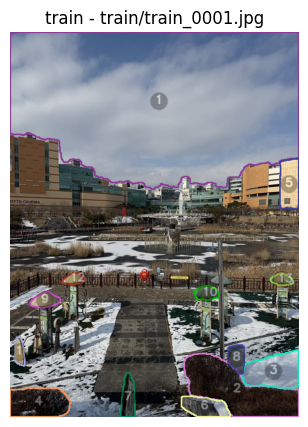

SAM2-train:  20%|██        | 1/5 [00:27<01:51, 27.97s/it]


 Image 1 | train/train_0002.jpg
→ 객체 개수: 4
→ centers: [(1, 275, 169), (2, 264, 590), (3, 508, 356), (4, 214, 671)]


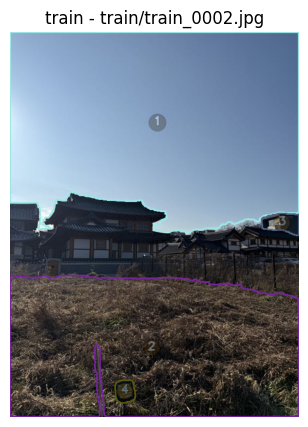

SAM2-train:  40%|████      | 2/5 [00:30<00:38, 12.93s/it]


 Image 2 | train/train_0003.jpg
→ 객체 개수: 7
→ centers: [(1, 233, 648), (2, 232, 649), (3, 64, 428), (4, 337, 586), (5, 271, 565), (6, 86, 528), (7, 424, 526)]


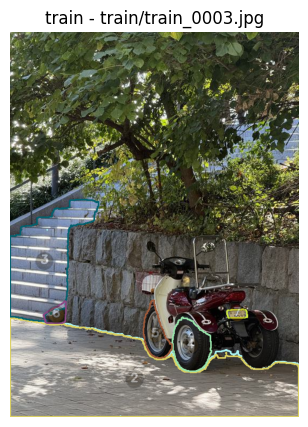

SAM2-train:  60%|██████    | 3/5 [00:32<00:16,  8.17s/it]


 Image 3 | train/train_0004.jpg
→ 객체 개수: 4
→ centers: [(1, 305, 105), (2, 129, 643), (3, 51, 93), (4, 111, 478)]


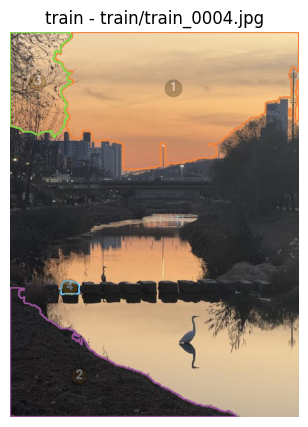

SAM2-train:  80%|████████  | 4/5 [00:35<00:05,  5.87s/it]


 Image 4 | train/train_0005.jpg
→ 객체 개수: 5
→ centers: [(1, 269, 189), (2, 277, 436), (3, 277, 436), (4, 242, 654), (5, 507, 532)]


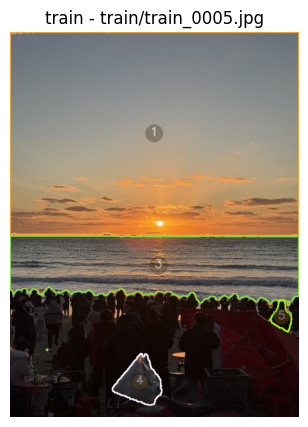

SAM2-train: 100%|██████████| 5/5 [00:37<00:00,  7.53s/it]

Done


In [6]:
run_sam(TRAIN_CSV, "train", sam2, k_per_image=25, overlay_alpha=0.35)